# Promotional Event Detection

In [2]:
# Import required modules (matplotlib and seaborn need to be installed for first time)
import matplotlib.pyplot as plt # Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python
import numpy as np # NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more
import pandas as pd # Pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool
import seaborn as sns # Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import scipy.stats as st # SciPy provides algorithms for optimization, integration, interpolation, eigenvalue problems, algebraic equations, differential equations, statistics and many other classes of problems
%matplotlib inline
# When using the 'inline' backend, your matplotlib graphs will be included in your notebook, next to the code

In [3]:
# Read the dataset file and load dataframe 'df'
dataset_file_path = r'Cripted_DB_Promo_detection.csv' # 'r' is for raw string
df = pd.read_csv(dataset_file_path, sep=';', decimal=',') # We use ';' as a separator because it's a semi-colon separated, should be ',' for comma separated
df.head() # Shows first rows of our dataframe

,CUSTOMER,PRODOTTO,YW,START_DATE,END_DATE,PriceUnits,PriceVolume,Units,Volume,Value,WD
0,Customer A,BABY DRY DUO DWCT,2018-05,43129,43135,11.900000,56.000000,136,28.9,1618.4,9
1,Customer A,BABY DRY DUO DWCT,2018-06,43136,43142,9.086016,46.537869,8717,1701.9,79202.8,93
2,Customer A,BABY DRY DUO DWCT,2018-07,43143,43149,9.118637,46.978016,13264,2574.6,120949.6,99
3,Customer A,BABY DRY DUO DWCT,2018-08,43150,43156,9.191366,47.439744,10493,2033.0,96445.0,98
4,Customer A,BABY DRY DUO DWCT,2018-09,43157,43163,10.450014,53.784368,3523,684.5,36815.4,94


In [4]:
# Data cleaning and drop null value rows
df.isnull().sum() # number of null rows in different columns (series)
df.shape # shape of our dataframe (row, column): (31242, 11)
df.dropna(how='any').shape # shape if we drop any null value row: (31239, 11)
df.dropna(how='any', inplace=True) # Using inplace will actually drop null values rows from our dataframe
# df.dropna(how='any', subset=['PriceVolume']) * We could do this either, because null values are in the PriceVolume Series

 # 1- Correlation Analysis

In [6]:
df.corr() # correlation table of variables
# np.corrcoef(df['Units'], df['Volume'])
# st.pearsonr(df['Units'], df['PriceUnits'])
# sns.regplot(data=df, x='Units', y='PriceUnits')

,START_DATE,END_DATE,PriceUnits,PriceVolume,Units,Volume,Value,WD
START_DATE,1.000000,1.000000,0.011834,-0.004176,-0.050881,-0.039572,-0.042761,-0.065284
END_DATE,1.000000,1.000000,0.011834,-0.004176,-0.050881,-0.039572,-0.042761,-0.065284
PriceUnits,0.011834,0.011834,1.000000,-0.187219,-0.144397,0.061244,0.048434,-0.359084
PriceVolume,-0.004176,-0.004176,-0.187219,1.000000,-0.121362,-0.167993,-0.130385,0.025043
Units,-0.050881,-0.050881,-0.144397,-0.121362,1.000000,0.805331,0.833796,0.420362
Volume,-0.039572,-0.039572,0.061244,-0.167993,0.805331,1.000000,0.980479,0.336700
Value,-0.042761,-0.042761,0.048434,-0.130385,0.833796,0.980479,1.000000,0.386146
WD,-0.065284,-0.065284,-0.359084,0.025043,0.420362,0.336700,0.386146,1.000000


# Using Numpy

In [84]:
np.corrcoef(df['PriceUnits'], df['WD']) # -0.35908411
np.corrcoef(df['PriceUnits'], df['PriceVolume']) # -0.18721943
np.corrcoef(df['PriceUnits'], df['Units']) # -0.14439663
np.corrcoef(df['PriceVolume'], df['Volume']) # -0.1679931
np.corrcoef(df['PriceUnits'], df['Volume']) # 0.06124389
np.corrcoef(df['Units'], df['WD']) # 0.42036153 
np.corrcoef(df['Units'], df['Volume']) # 0.8053307
np.corrcoef(df['Units'], df['Value']) # 0.83379606
np.corrcoef(df['Value'], df['WD']) # 0.38614571
np.corrcoef(df['Value'], df['Volume']) # 0.98047871

array([[ 1.        , -0.14439663],
       [-0.14439663,  1.        ]])

# Using Scipy

In [86]:
st.pearsonr(df['PriceUnits'], df['WD']) 
# -0.35908411273655283 negative correlation
st.pearsonr(df['PriceUnits'], df['PriceVolume']) 
# -0.18721943199351052 negative correlation
st.pearsonr(df['PriceUnits'], df['Units']) 
# -0.14439663490252186 negative correlation
st.pearsonr(df['PriceVolume'], df['Volume']) 
# -0.16799310096604553 negative correlation
st.pearsonr(df['PriceUnits'], df['Volume']) 
# 0.0612438890101534 positive correlation
st.pearsonr(df['Units'], df['WD']) 
# 0.42036153030323437 positive correlation
st.pearsonr(df['Units'], df['Volume']) 
# 0.8053307046287838 positive correlation
st.pearsonr(df['Units'], df['Value']) 
# 0.833796061095855 positive correlation
st.pearsonr(df['Value'], df['WD']) 
# 0.3861457083393341 positive correlation
st.pearsonr(df['Value'], df['Volume']) 
# 0.9804787118459396 positive correlation

(0.9804787118459396, 0.0)

# Data Visualization

<AxesSubplot:>

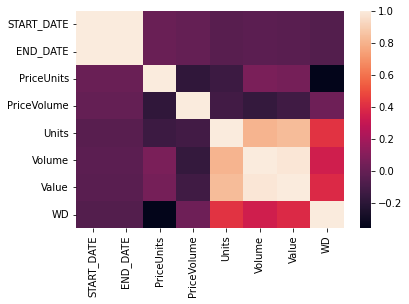

In [73]:
sns.heatmap(df.corr()) # correlation heatmap

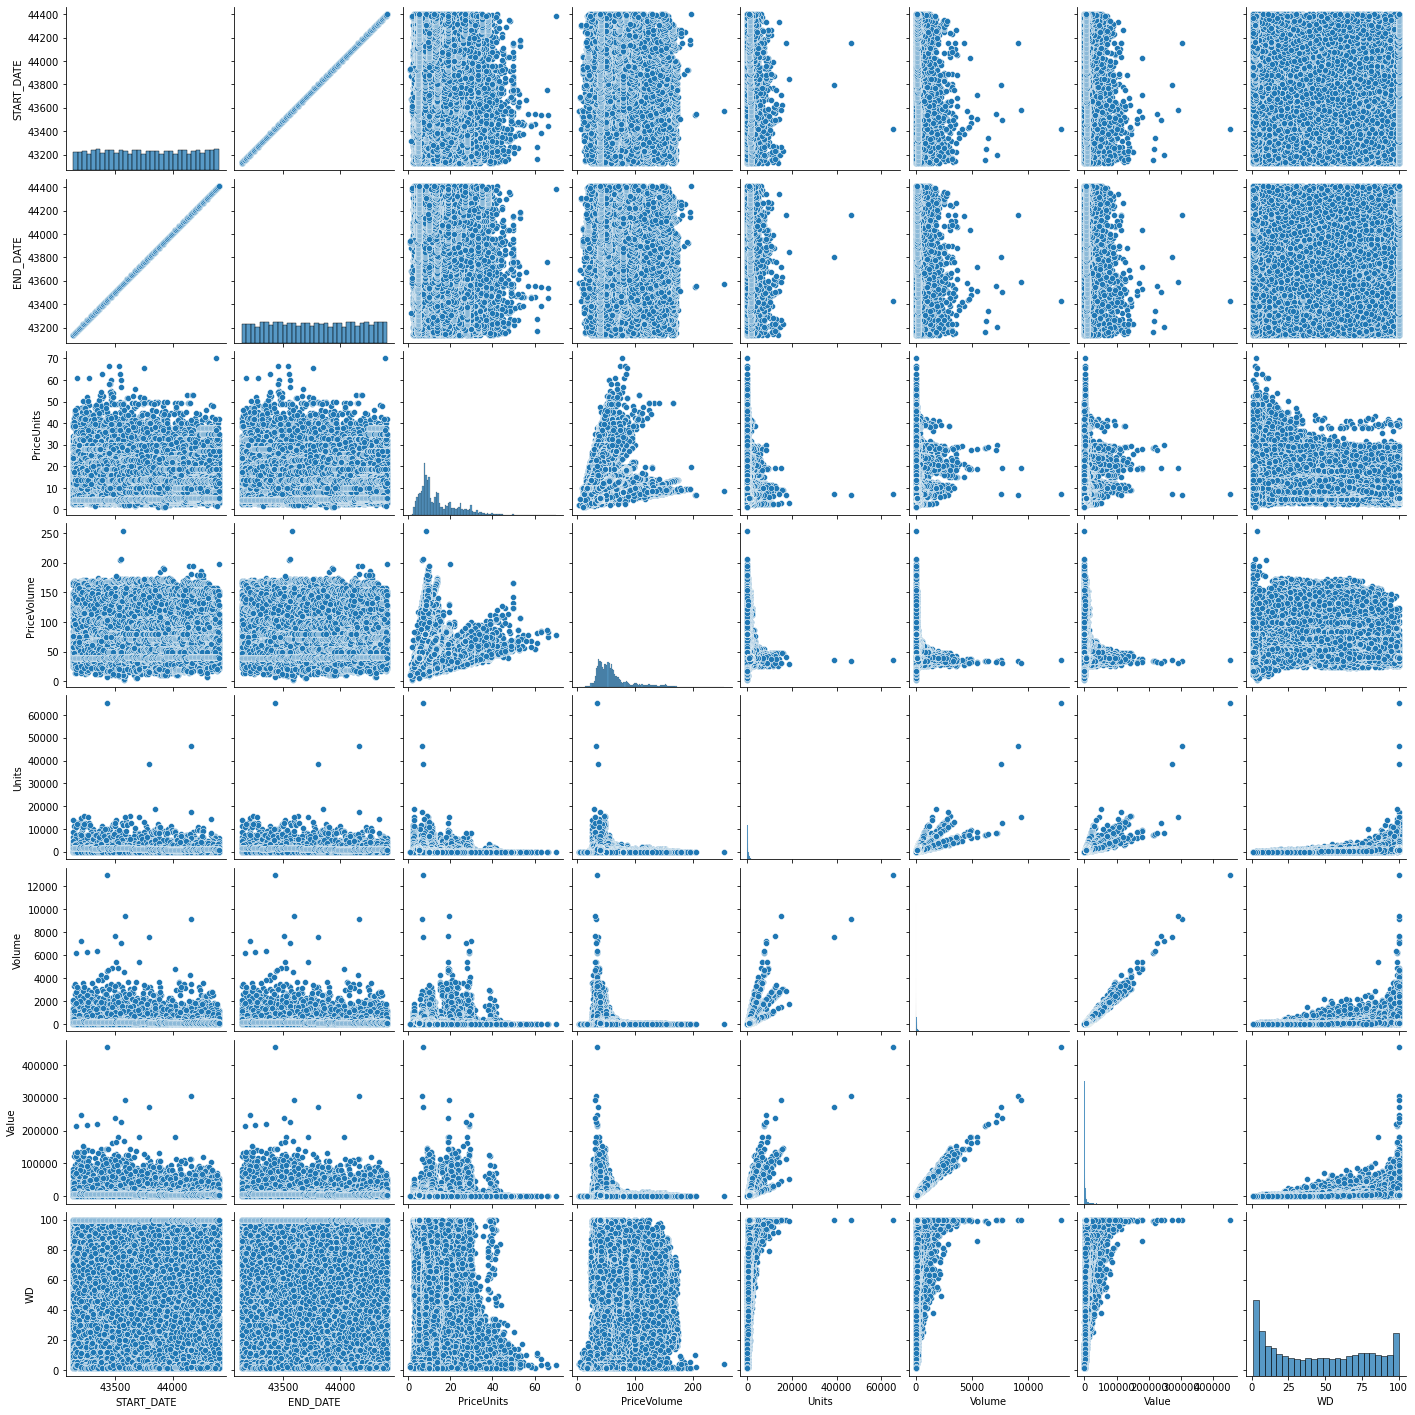

In [71]:
sns.pairplot(df) # representation, Pair Grid

<AxesSubplot:ylabel='Value'>

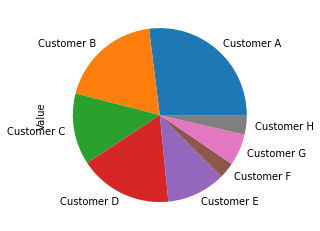

In [139]:
df.groupby(['CUSTOMER'])['Value'].sum().plot(kind='pie') # Total-value of each Customer

# 2- Promotional Weeks Detection

In [114]:
df.groupby('YW')[['Value']].sum() # Groupby single column
df.groupby('YW')[['Value', 'Units']].sum() # Groupby multible columns

,Value,Units
YW,,
2018-05,989947.2,100708
2018-06,937448.8,91849
2018-07,915589.9,86901
2018-08,896165.0,89661
2018-09,1130090.9,95840
...,...,...
2021-26,796921.5,71596
2021-27,787709.9,71635
2021-28,827355.5,72615


In [149]:
df.groupby(['YW', 'CUSTOMER', 'PRODOTTO'])['Value'].sum() # Groupby single column

YW       CUSTOMER    PRODOTTO                 
2018-05  Customer A  BABY DRY DUO DWCT             1618.4
                     BABY DRY DWCT                 5276.5
                     BABY DRY TRIO DWCT           83953.2
                     COMPETITION 11                 863.3
                     COMPETITION 12                7176.0
                                                   ...   
2021-30  Customer H  COMPETITION 7                  614.3
                     PROGRESSI CP                  3379.1
                     PROGRESSI IL MUTANDINO CP      798.7
                     SOLE E LUNA CP                 768.9
                     SOLE E LUNA VP                 141.0
Name: Value, Length: 31214, dtype: float64